In [2]:
import jsonlines
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark import SparkContext
import numpy as np
import json
from tqdm import tqdm
import statsmodels.api as smf

## Popular climate change video analysis :)

### are they from already famous yt channels?

In [3]:
file_path = "data/climate_videos_v3.jsonl"
videos_df = pd.read_json(file_path, lines=True)

In [4]:
videos_df.dropna(inplace=True, subset='view_count')
videos_df.sort_values(by='view_count', inplace=True, ascending=False)

In [5]:
videos_df.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,classification_categories
59893,Science & Technology,UC3O8-tKnz9VUn3sxZKyKN3w,2019-10-29 22:11:35.842626,India is amongst the top 5 countries in e-wast...,435.0,cFAylV8Wkwk,45,2302.0,"save environment,clean india,e waste,samsung v...",Samsung Care For Clean India Program,2019-07-28 00:00:00,144849603,{'/Computers & Electronics/Consumer Electronic...
13459,Entertainment,UCxo37Wc-azMveu1NXiCcAFA,2019-11-13 13:28:44.300683,While many of you may have asked who is Suraj ...,73761.0,QN7BFBqZ6qo,179,299040.0,"Suraj,Chakravarti,Viral,Funny,Hitachi AC,Funny...",Know the reason for extreme heat this summer! ...,2018-05-29 00:00:00,110302967,{'/Science/Ecology & Environment/Climate Chang...
26718,Nonprofits & Activism,UCTZmwwn0Wd5YsAxw0NZzyJA,2019-10-31 17:47:36.335709,Water is the world’s most precious resource. N...,51125.0,677R2ezfAT8,60,112417.0,"WWF,WWF-Pakistan,World Water Week,Freshwater,S...",Elephant vs Giraffe Water Fight,2018-08-27 00:00:00,87753613,"{'/Pets & Animals/Wildlife': 0.8440645337, '/P..."
67200,People & Blogs,UCt4yIZtfFMKoQAflz4gIA1Q,2019-11-18 16:08:27.157077,This is the original video! Filmed by Christin...,29177.0,4wH878t78bw,487,275795.0,"Drinking Straw (Product Category),Turtle (Anim...","Sea Turtle with Straw up its Nostril - ""NO"" TO...",2015-08-10 00:00:00,38336293,{'/People & Society/Social Issues & Advocacy/G...
49523,Education,UCBnZ16ahKA2DZ_T5W0FPUXg,2019-11-18 13:19:51.914822,Here We Go Round the Mulberry Bush | Popular N...,NaN,55pHnLYhF5Q,162,NaN,"Here We Go Round the Mulberry Bush,mulberry bu...",Here We Go Round the Mulberry Bush | Save the ...,2014-11-07 00:00:00,36984411,{'/People & Society/Kids & Teens/Children's In...


### The channels with the most influence with climate change related videos

In [6]:
views_climate_df = videos_df.groupby('channel_id').agg({'view_count': 'sum'}).reset_index().sort_values(by='view_count', ascending=False)
display(views_climate_df.head())

,channel_id,view_count
383,UC3O8-tKnz9VUn3sxZKyKN3w,161728096
5625,UCxo37Wc-azMveu1NXiCcAFA,110902089
2767,UCTZmwwn0Wd5YsAxw0NZzyJA,87795704
5182,UCt4yIZtfFMKoQAflz4gIA1Q,44722801
1942,UCKLwLnQt6svrAeL9DgAAFqg,37925268


In [7]:
channels_path = 'data/df_channels_en.tsv'

ratios = videos_df['channel_id'].value_counts().reset_index()
ratios.columns = ['channel', 'count_climate_videos']

channels_df = pd.read_csv(channels_path, delimiter='\t')

channels_views_df = channels_df.merge(ratios, on ='channel', how ='left').fillna(0)
channels_views_df['proportion_climate_videos'] = channels_views_df['count_climate_videos']/channels_views_df['videos_cc']

views_climate_df.rename(columns={'channel_id': 'channel'}, inplace=True)
channels_views_df = channels_views_df.merge(views_climate_df, on ='channel', how ='left').fillna(0)

channels_views_df.sort_values(by='view_count', inplace=True, ascending=False)

In [8]:
display(channels_views_df.head())

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_climate_videos,proportion_climate_videos,view_count
1143,Science & Technology,2009-06-29,UC3O8-tKnz9VUn3sxZKyKN3w,SamsungIndia,4010000,166,2251.0,2.1530,2.0,0.012048,161728096.0
20927,Science & Technology,2011-05-28,UCxo37Wc-azMveu1NXiCcAFA,Hitachi Cooling & He...,249000,127,62453.0,3.8515,2.0,0.015748,110902089.0
22626,Nonprofits & Activism,2016-08-03,UCTZmwwn0Wd5YsAxw0NZzyJA,WWF - Pakistan,170000,209,69093.0,3.9055,34.0,0.162679,87795704.0
35171,People & Blogs,2014-05-26,UCt4yIZtfFMKoQAflz4gIA1Q,Sea Turtle Biologist...,135735,10,120383.0,4.0930,2.0,0.200000,44722801.0
124422,Nonprofits & Activism,2009-06-12,UCKLwLnQt6svrAeL9DgAAFqg,SouthCoastAQMD,13700,780,789390.0,10.2765,58.0,0.074359,37925268.0


### Regression to see if cc videos attract new viewers

In [9]:
#col = ['channel_id', 'display_id', 'view_count']
videos_df.rename(columns={'channel_id': 'channel'}, inplace=True)

#sample_vid_df = pd.read_json('data/sampled_dataset_01percent.jsonl', lines=True)
#sample_vid_df.rename(columns={'channel_id': 'channel'}, inplace=True)
#sample_vid_df = sample_vid_df.head(1000)

videos_subscribers_df = videos_df.merge(channels_df, on ='channel', how ='left').fillna(0)
columns_keep = ['channel', 'subscribers_cc', 'view_count']
videos_subscribers_df = videos_subscribers_df[columns_keep]
videos_subscribers_df.sort_values(by='subscribers_cc', inplace=True, ascending=False)

display(videos_subscribers_df.head())

,channel,subscribers_cc,view_count
291,UCq-Fj5jknLsUf-MWSy4_brA,112139463,1060271
169,UC295-Dw_tDNtZXFeAPAW6Aw,60600000,1607483
229,UCJ5v_MCY6GNUBTO8-D3XoAg,48400000,1271652
2409,UC4rlAVgAK0SGk-yTfe48Qpw,29800000,103692
1080,UC4rlAVgAK0SGk-yTfe48Qpw,29800000,267151


                            OLS Regression Results                            
Dep. Variable:             view_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     30.73
Date:                Sat, 16 Dec 2023   Prob (F-statistic):           2.98e-08
Time:                        17:32:32   Log-Likelihood:            -1.0574e+06
No. Observations:               70231   AIC:                         2.115e+06
Df Residuals:                   70229   BIC:                         2.115e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.579e+04   3340.576      7.

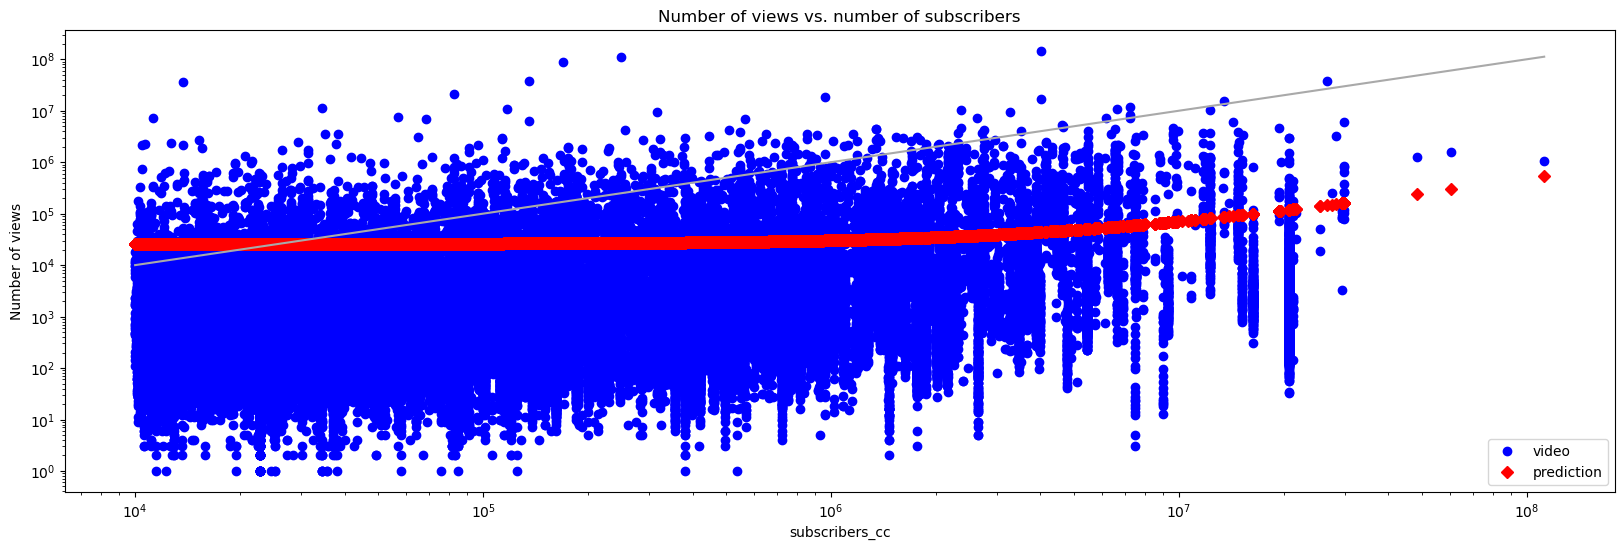

In [10]:
fig, ax = plt.subplots(figsize = (20, 6))

x = range(10**4, 112139463, 1000)

#plt.scatter(videos_subscribers_df.view_count, videos_subscribers_df.subscribers_cc, alpha=0.1)
model = smf.formula.ols(formula='view_count ~ subscribers_cc', data=videos_subscribers_df, missing='drop').fit()
smf.graphics.plot_fit(model, 1, ax=ax, vlines=False)
ax.set_xscale("log")
ax.set_yscale("log")
print(model.summary())

plt.plot(x, x, color='darkgray')

plt.title('Number of views vs. number of subscribers')
plt.legend(['video', 'prediction'], loc='lower right')
plt.ylabel('Number of subscribers')
plt.ylabel('Number of views')
plt.show()

instead of subscribers avg view_count cuz it will tell us more

In [11]:
timeseries_df = pd.read_csv('DATA/df_timeseries_en.tsv', delimiter='\t')
display(timeseries_df.head(2))

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03 00:00:00,202494.555556,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10 00:00:00,394085.666667,191591.111111,1046.000000,395.777778,6,1,1


In [12]:
tt_views_df = timeseries_df[['channel', 'views', 'videos']] #j'espere c'est sort par datetime pour chaque channel
tt_views_df = tt_views_df.groupby('channel').last()
tt_views_df.rename(columns={'views': 'tt_views', 'videos': 'tt_videos'}, inplace=True)
display(tt_views_df.head())

,tt_views,tt_videos
channel,,
UC--24Q3_ZQeFmgJE-Um5QZQ,4.356804e+06,188
UC--2EbuIuBOGgGqPiJxi3rg,7.951972e+06,60
UC--3c8RqSfAqYBdDjIG3UNA,5.798712e+07,333
UC--3ozenTzry39-xMqAPQlw,1.455123e+07,43
UC--6E6EpybocdaNlPhvK_9A,9.166274e+06,31


In [13]:
tt_views_cc_df = videos_df[['channel', 'view_count']].groupby('channel').agg(['sum', 'count'])
tt_views_cc_df.columns = tt_views_cc_df.columns.to_flat_index()
tt_views_cc_df.rename(columns={('view_count', 'sum'): 'tt_cc_views', ('view_count', 'count'): 'tt_cc_videos'}, inplace=True)
display(tt_views_cc_df.head(2))

,tt_cc_views,tt_cc_videos
channel,,
UC--70ql_IxJmhmqXqrkJrWQ,7604,1
UC-1rx8j9Ggp8mp4uD0ZdEIA,10305,1


In [14]:
vid_views_df = tt_views_df.merge(tt_views_cc_df, how='inner', on='channel')
vid_views_df['avg_views_wo_cc'] = (vid_views_df['tt_views'] - vid_views_df['tt_cc_views'])/(vid_views_df['tt_videos'] - vid_views_df['tt_cc_videos'])
vid_views_df['avg_views_w_cc'] = vid_views_df['tt_cc_views']/vid_views_df['tt_cc_videos']
vid_views_df['avg_views'] = vid_views_df['tt_views']/vid_views_df['tt_videos']
display(vid_views_df.head(2))
# croyez le ou non des channels ont plus de videos cc que de videos totales
# et c'est pas pcq ils ont plus de videos tt que de videos cc que y'a plus de vues tt que de vues cc

,tt_views,tt_videos,tt_cc_views,tt_cc_videos,avg_views_wo_cc,avg_views_w_cc,avg_views
channel,,,,,,,
UC--70ql_IxJmhmqXqrkJrWQ,2.070418e+07,243,7604,1,85523.031877,7604.0,85202.377425
UC-1rx8j9Ggp8mp4uD0ZdEIA,9.329747e+08,4190,10305,1,222717.680115,10305.0,222666.984964


In [15]:
vid_views_df = vid_views_df[vid_views_df['tt_cc_videos']<vid_views_df['tt_videos']].dropna()
vid_views_df = vid_views_df[vid_views_df['avg_views_wo_cc']>0].dropna()

# debug weird values
jsp2 = vid_views_df[['avg_views_wo_cc']].idxmin()
display(vid_views_df.loc[jsp2[0]])

C:\Users\nasta\AppData\Local\Temp\ipykernel_24952\1173963796.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  display(vid_views_df.loc[jsp2[0]])


tt_views           127379.011905
tt_videos             961.000000
tt_cc_views           135.000000
tt_cc_videos            1.000000
avg_views_wo_cc       132.545846
avg_views_w_cc        135.000000
avg_views             132.548399
Name: UCd6V9TvLWmHmTTM29tUDGpg, dtype: float64

                            OLS Regression Results                            
Dep. Variable:        avg_views_wo_cc   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     1570.
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          1.40e-303
Time:                        17:33:16   Log-Likelihood:                -86089.
No. Observations:                5725   AIC:                         1.722e+05
Df Residuals:                    5723   BIC:                         1.722e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.123e+05   1.09e+04     10.

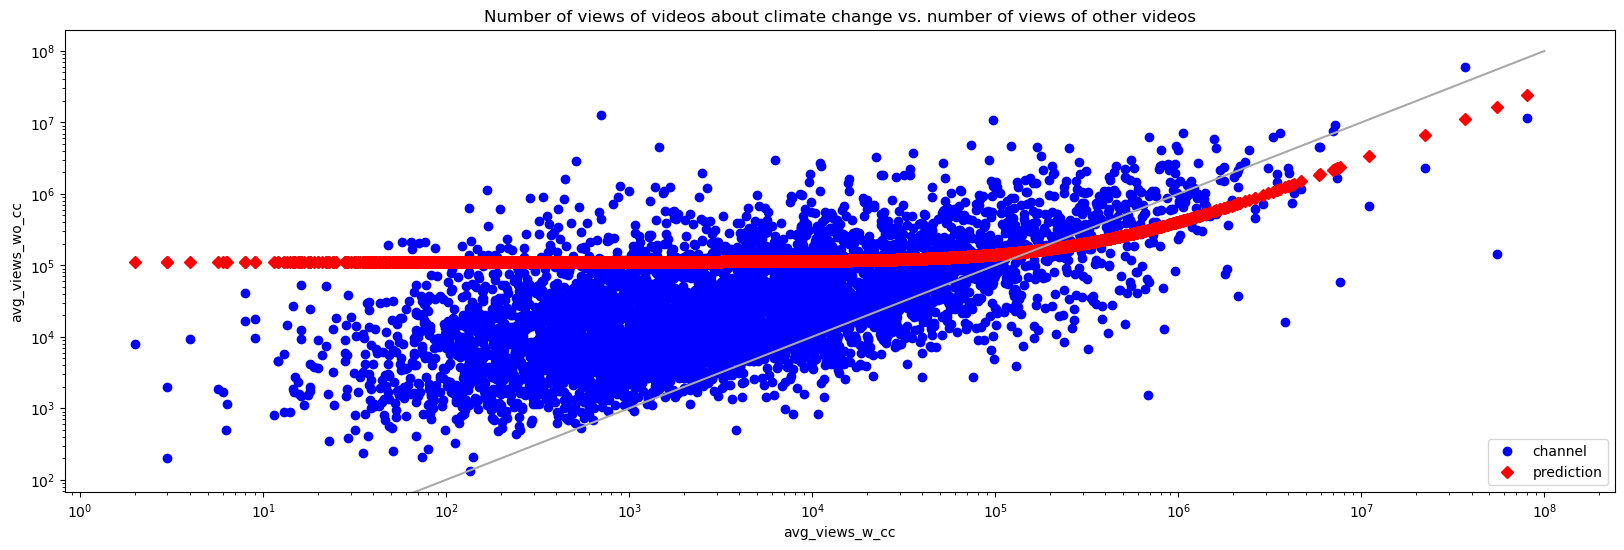

In [16]:
fig, ax = plt.subplots(figsize = (20, 6))

model2 = smf.formula.ols(formula='avg_views_wo_cc ~ avg_views_w_cc', data=vid_views_df, missing='drop').fit()
smf.graphics.plot_fit(model2, 1, ax=ax, vlines=False)
ax.set_xscale("log")
ax.set_yscale("log")
print(model2.summary())

x = range(0, 10**8, 1000)
plt.plot(x, x, color='darkgray')

plt.title('Number of views of videos about climate change vs. number of views of other videos')
plt.legend(['channel', 'prediction'], loc='lower right')
#plt.ylabel('Views of videos not about climate change')
#plt.ylabel('Views of videos about climate change')
plt.show()

In [114]:
ch_views_df = vid_views_df.sort_values(by='tt_cc_videos', ascending=False)
ch_views_df = ch_views_df.merge(channels_views_df[['channel', 'name_cc', 'subscribers_cc', 'proportion_climate_videos']], on ='channel', how ='inner').fillna(0)
ch_views_df = ch_views_df.set_index('name_cc')
ch_views_df = ch_views_df.sort_values(by='proportion_climate_videos', ascending=False)
channels20_df = ch_views_df.head(10)
display(ch_views_df.head(10))

,channel,tt_views,tt_videos,tt_cc_views,tt_cc_videos,avg_views_wo_cc,avg_views_w_cc,avg_views,subscribers_cc,proportion_climate_videos
name_cc,,,,,,,,,,
Rob Greenfield,UCKirXBZV7hE4Fws3VSdYkRQ,5.506280e+06,206,5008132,161,11069.949206,31106.409938,26729.513176,116000,0.763033
The YEARS Project,UCxJf58pbfCYiDOKxRTJI9cA,3.098489e+06,494,2795338,338,1943.276366,8270.230769,6272.245168,21700,0.686992
1000frolly PhD,UCAR0Oi4L0Om4F26uwpANgCg,1.034144e+07,167,9356772,106,16142.053864,88271.433962,61924.774166,31300,0.634731
Climate Reality,UCIJk74xZtFZut1rJVHVVXeA,4.029099e+06,522,3174000,320,4233.162659,9918.750000,7718.580186,15655,0.613027
Just Have a Think,UCRBwLPbXGsI2cJe9W1zfSjQ,1.362583e+06,75,818670,43,16997.278088,19038.837209,18167.771984,29500,0.581081
Guy Brown,UCa5FbtOmZvP0Z6wR4n7jL8w,5.032664e+06,624,1694718,353,12317.145493,4800.900850,8065.167353,26200,0.564800
Our Changing Climate...,UCNXvxXpDJXp-mZu3pFMzYHQ,8.013691e+06,78,3628840,44,128966.198004,82473.636364,102739.624771,171000,0.556962
Climate State,UCXy9Efp5QoTGGxmpKBujLLQ,7.079024e+06,45,778977,30,420003.103030,25965.900000,157311.634343,28700,0.555556
Friends of Science,UCSjTdgNgUW7VNfemabYV3Kg,1.643781e+06,308,1289450,170,2567.616977,7585.000000,5336.951763,13800,0.551948


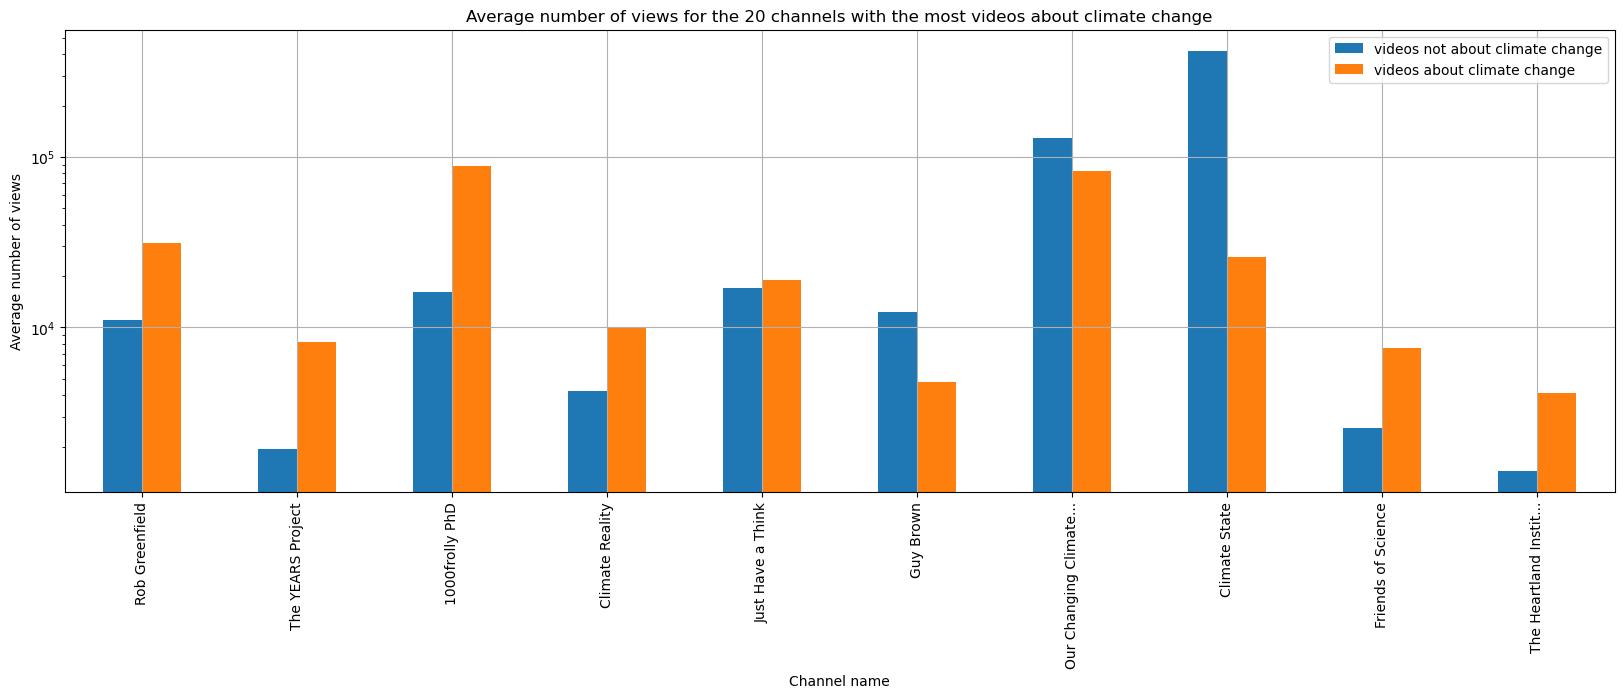

In [115]:
fig, ax = plt.subplots(figsize = (20, 6))
channels20_df[['avg_views_wo_cc', 'avg_views_w_cc']].plot(kind='bar', grid=True, ax=ax)
ax.set_yscale("log")

plt.title('Average number of views for the 20 channels with the most videos about climate change')
plt.legend(['videos not about climate change', 'videos about climate change'], loc='upper right')
plt.ylabel('Average number of views')
plt.xlabel('Channel name')
plt.show()

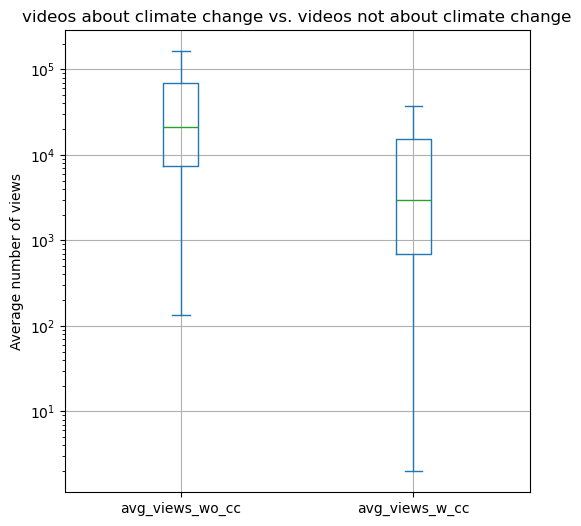

In [19]:
fig, ax = plt.subplots(figsize = (6, 6))

#color = {
#    "boxes": "DarkGreen",
#    "whiskers": "DarkOrange",
#    "medians": "DarkBlue",
#    "caps": "Gray",
#}

ch_views_df[['avg_views_wo_cc', 'avg_views_w_cc']].plot(kind='box', grid=True, ax=ax, showfliers=False) #, color=color
ax.set_yscale("log")

plt.title('videos about climate change vs. videos not about climate change')
#plt.legend(['videos not about climate change', 'videos about climate change'], loc='upper right')
plt.ylabel('Average number of views')
#plt.xlabel('Channel name')
plt.show()

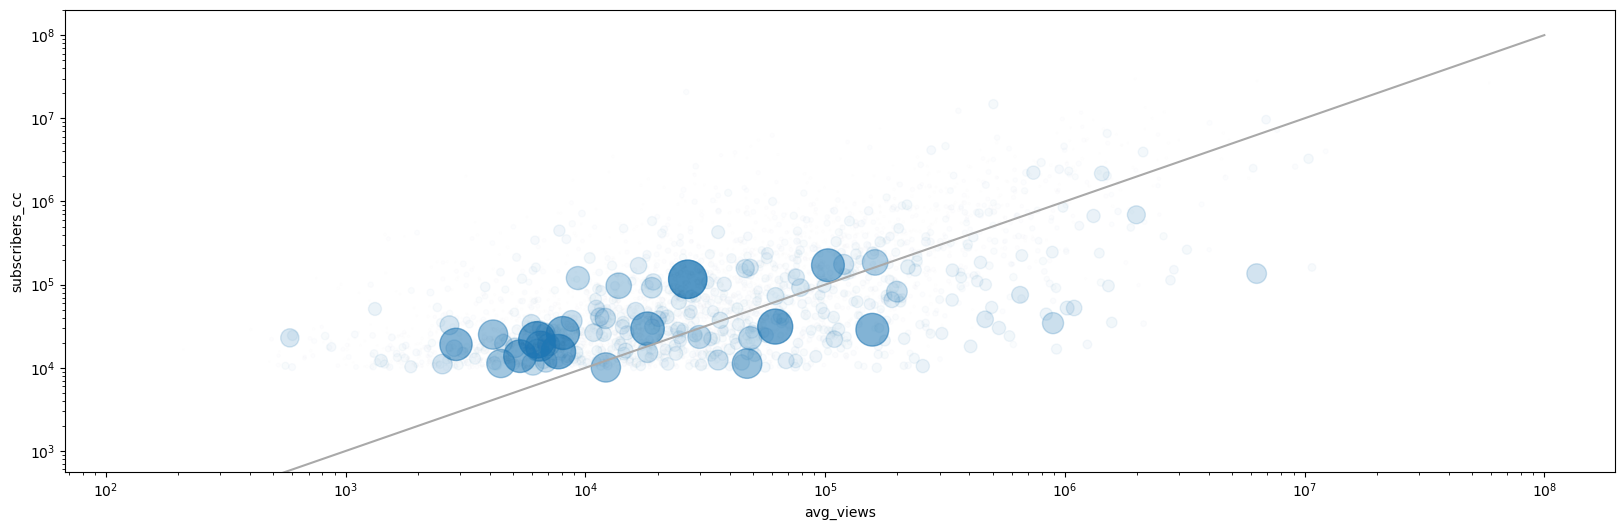

In [20]:
fig, ax = plt.subplots(figsize = (20, 6))

ch_views_df.plot.scatter(x='avg_views', y='subscribers_cc', s=ch_views_df['proportion_climate_videos']*1000, ax=ax, alpha=ch_views_df['proportion_climate_videos'])
#ch_views_df.plot.scatter(x='avg_views', y='subscribers_cc', s=(1-ch_views_df['proportion_climate_videos'])*3000, ax=ax, color='red', alpha=0.5)

x = range(0, 10**8, 1000)
plt.plot(x, x, color='darkgray')

ax.set_xscale("log")
ax.set_yscale("log")

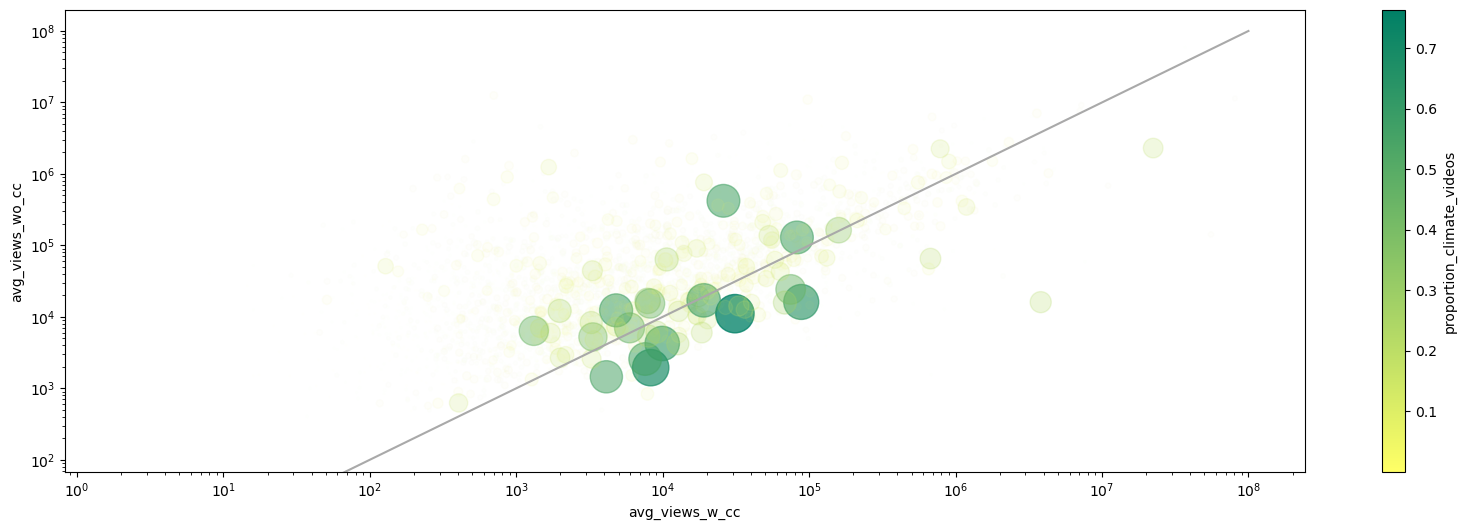

In [21]:
fig, ax = plt.subplots(figsize = (20, 6))

ch_views_df.plot.scatter(x='avg_views_w_cc', y='avg_views_wo_cc', s=ch_views_df['proportion_climate_videos']*1000, ax=ax, alpha=ch_views_df['proportion_climate_videos'], c='proportion_climate_videos', colormap='summer_r')
#ch_views_df.plot.scatter(x='avg_views', y='subscribers_cc', s=(1-ch_views_df['proportion_climate_videos'])*3000, ax=ax, color='red', alpha=0.5)

x = range(0, 10**8, 1000)
plt.plot(x, x, color='darkgray')

ax.set_xscale("log")
ax.set_yscale("log")

La j'ai l'imp que les channels avec un gros ratio de cc vid elles sont quand meme plus importantes dans le game

le graph suivant c'est le même sauf que la taille ne depend plus du ratio mais de la quantité de videos faites

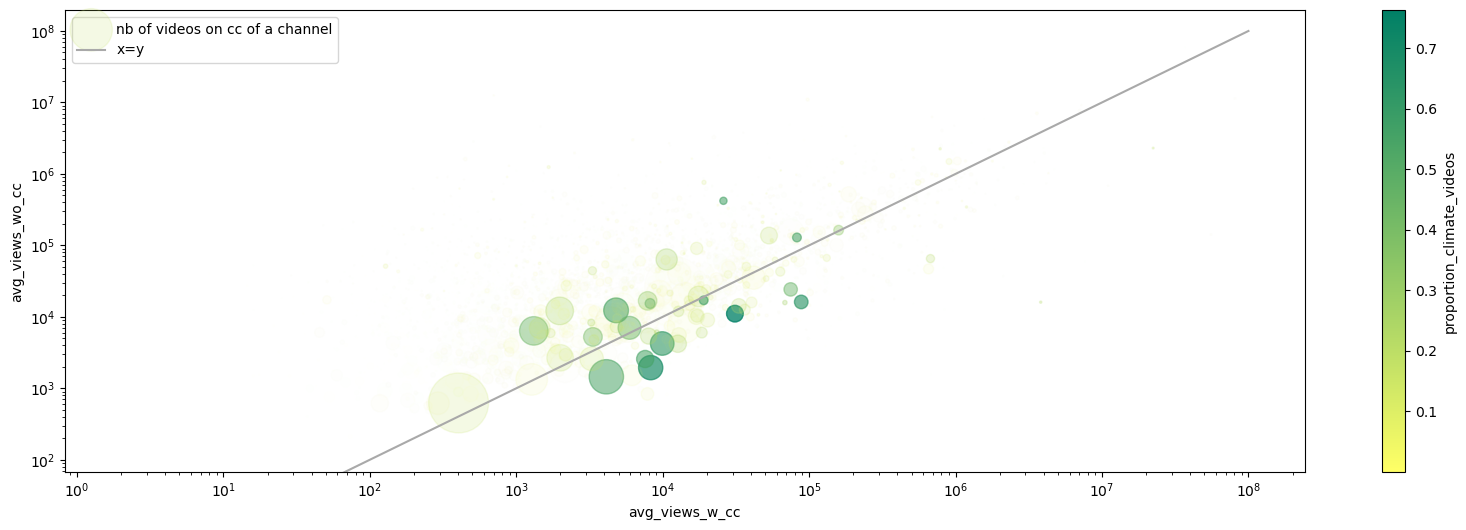

In [22]:
fig, ax = plt.subplots(figsize = (20, 6))

#tt = ch_views_df['tt_cc_videos'].sum()

#ch_views_df.plot.scatter(x='avg_views_w_cc', y='avg_views_wo_cc', s=ch_views_df['tt_cc_videos'], ax=ax, alpha=ch_views_df['proportion_climate_videos']) #alpha=ch_views_df['tt_cc_videos']*30/tt
ch_views_df.plot.scatter(x='avg_views_w_cc', y='avg_views_wo_cc', s=ch_views_df['tt_cc_videos']*0.9, ax=ax, c='proportion_climate_videos', colormap='summer_r', alpha=ch_views_df['proportion_climate_videos'])

x = range(0, 10**8, 1000)
plt.plot(x, x, color='darkgray')

ax.set_xscale("log")
ax.set_yscale("log")

plt.legend(['nb of videos on cc of a channel', 'x=y'], loc='upper left')

# plus les ronds sont gros plus y'a de videos cc
# plus les ronds sont fonces plus la chaine a un haut ratio de videos cc

On considerait toutes les chaines qui avaient des videos sur le climate change et on comparait leur moyenne de vues
pour leurs videos avec et sans le topic du cc.  
Maintenant on considere les channels qui ont un ration sup à 25% donc qui sont des channels dont le sujet du cc
c'est imp et du coup ptet leurs subscribers les suit en partie pour cette raison.  
Du coup on va voir si être dans le theme du cc et faire des videos dessus c'est benef.

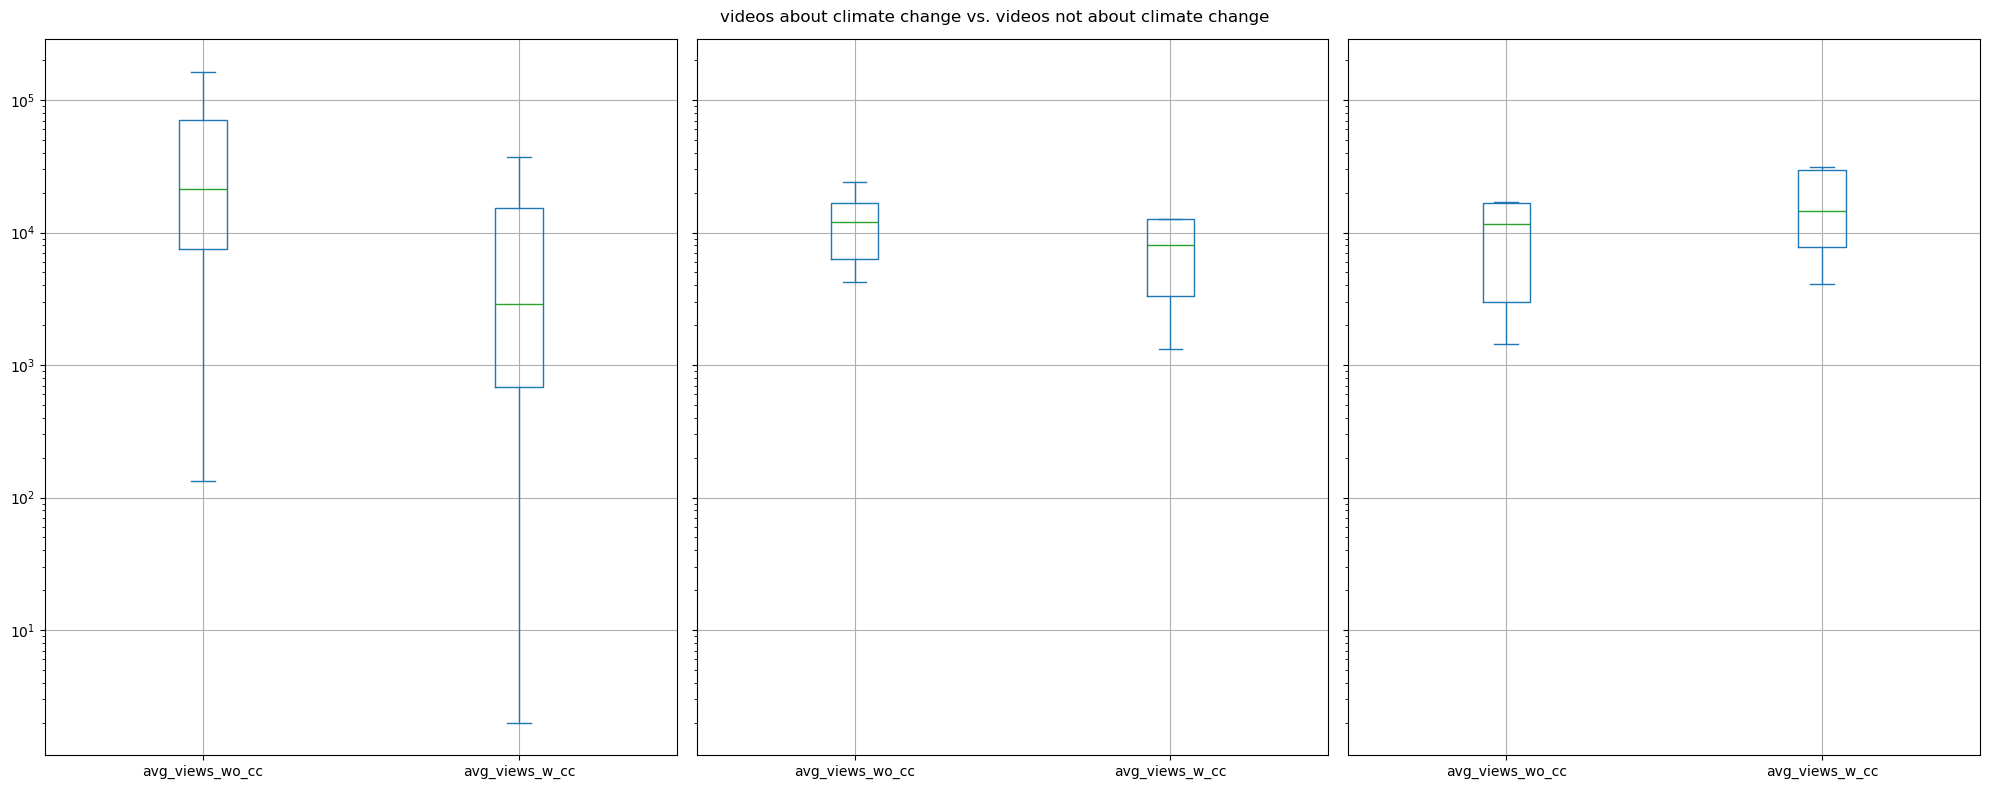

In [23]:
ch_views_cc25_df = ch_views_df[ch_views_df['proportion_climate_videos'] <= 0.25].dropna()
ch_views_cc50_df = ch_views_df[(ch_views_df['proportion_climate_videos'] > 0.25) & (ch_views_df['proportion_climate_videos'] <= 0.5)].dropna()
#display(ch_views_cc50_df['avg_views_w_cc'])
#ch_views_cc75_df = ch_views_df[(ch_views_df['proportion_climate_videos'] > 0.5) & (ch_views_df['proportion_climate_videos'] <= 0.75)].dropna()
ch_views_cc100_df = ch_views_df[ch_views_df['proportion_climate_videos'] > 0.5].dropna()
#display(ch_views_cc100_df)

fig, (pA, pB, pD) = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

ch_views_cc25_df[['avg_views_wo_cc', 'avg_views_w_cc']].plot(kind='box', grid=True, ax=pA, showfliers=False)
ch_views_cc50_df[['avg_views_wo_cc', 'avg_views_w_cc']].plot(kind='box', grid=True, ax=pB, showfliers=False)
#ch_views_cc75_df[['avg_views_wo_cc', 'avg_views_w_cc']].plot(kind='box', grid=True, ax=pC, showfliers=False)
ch_views_cc100_df[['avg_views_wo_cc', 'avg_views_w_cc']].plot(kind='box', grid=True, ax=pD, showfliers=False)
pA.set_yscale("log")

fig.suptitle('videos about climate change vs. videos not about climate change')
fig.tight_layout()
#plt.legend(['videos not about climate change', 'videos about climate change'], loc='upper right')
plt.ylabel('Average number of views')
#plt.xlabel('Channel name')
plt.show()

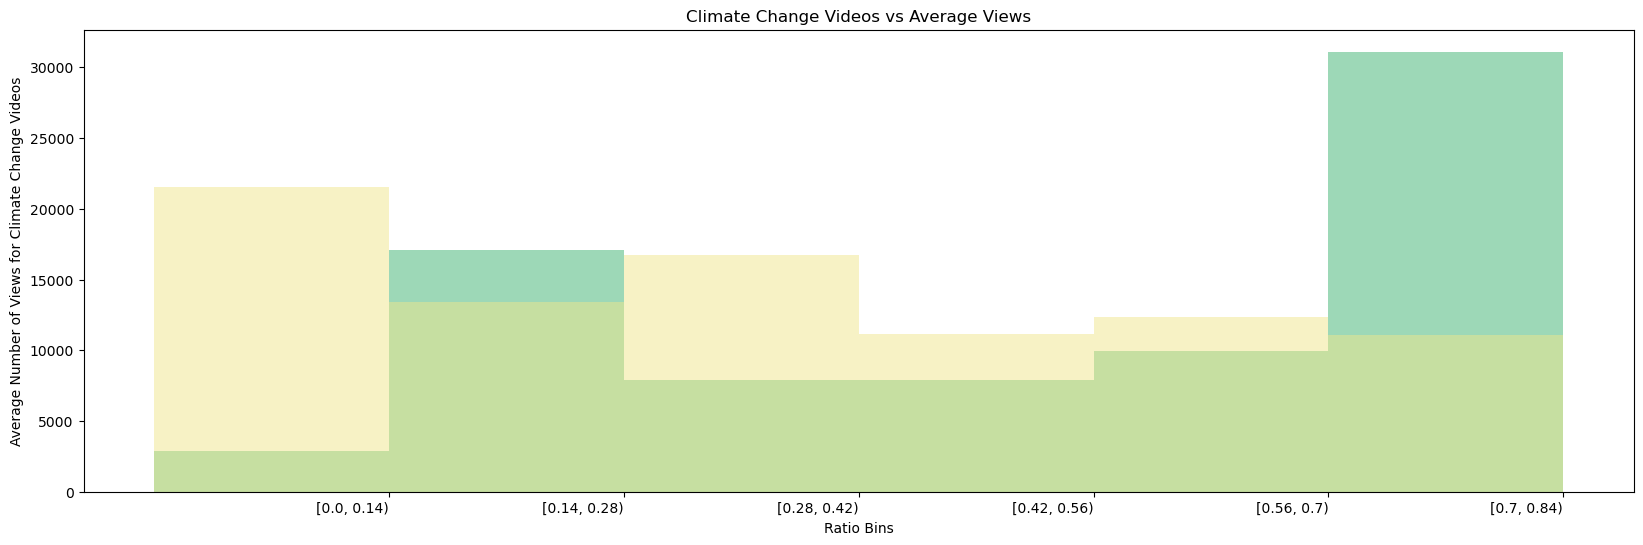

In [74]:
fig, ax = plt.subplots(figsize = (20, 6))
#bins = (0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8)
bins = np.arange(0, 1.16, 0.14)

# Cut the 'Ratio' column into the specified bins
ch_views_df['RatioBin'] = pd.cut(ch_views_df['proportion_climate_videos'], bins=bins, right=False)

first_slice_df = ch_views_df[ch_views_df['RatioBin'] == ch_views_df['RatioBin'].iloc[5700]]
#display(first_slice_df)

# Group by the bins and calculate the average number of views for each bin
grouped_df = ch_views_df.groupby('RatioBin', observed=True)['avg_views_w_cc'].median()
grouped_df2 = ch_views_df.groupby('RatioBin', observed=True)['avg_views_wo_cc'].median()

#display(grouped_df)
# Plot the graph
ax.bar(range(len(grouped_df)), grouped_df, alpha=0.5, width=-1, align='edge', color='mediumseagreen')
ax.bar(range(len(grouped_df2)), grouped_df2, alpha=0.5, width=-1, align='edge', color='khaki')
plt.xlabel('Ratio Bins')
plt.ylabel('Average Number of Views for Climate Change Videos')
plt.title('Climate Change Videos vs Average Views')
plt.xticks(range(len(grouped_df)), grouped_df.index, ha='right')
plt.show()

Ptet faire la meme sauf considérer au dessus de 50 et pas faire la derniere pcq je crois y'a pas beaucoup de chaines qui ont un tel ratio donc pas tres parlant  

Aussi on voit que dans le premier plot il y a quand meme pas mal de videos qui ont percées de manière hors norme mais c'est aussi le cas pour les vids wo cc  
  
Du coup la datastory serait: si t'es pas dans le monde du cc faire une video dessus ne t'apportera pas plus de vues  
Par contre si ta chaine elle est stylée et qu'elle parle du cc faire des vids dessus vu que ton puplic ça l'intéresse ça fait + de vues

## Est-ce qu'une video doit etre avant ou apres un event pour qu'elle perce ?

I think 52 events is a bit much  
Or maybe do the same but with the 10 most important events  
le pb c'est qu'on considere quoi comme evenement important ? pcq on peut pas prendre celui qui a eu le + de vues ça biaiserait de fou l'analyse faudrait demander une plus petite liste à chatGPT

In [25]:
climate_events = pd.read_csv('data/climate_events.csv')
climate_events['date'] = pd.to_datetime(climate_events['date'])

# y'avais des events qui se repettaient donc je les ai enlevés

In [26]:
climate_events['before_event'] = climate_events['date'] - pd.Timedelta(days=8)
climate_events['after_event'] = climate_events['date'] + pd.Timedelta(days=7)

#climate_events.set_index('date', inplace=True)
#climate_events.sort_index(inplace=True)
#climate_events = climate_events.loc['2010': '2019-09-28']

display(climate_events.head(2))
print(climate_events.shape)

,date,name_of_event,before_event,after_event
0,2010-01-12,Haiti Earthquake and Its Impact on Vulnerable ...,2010-01-04,2010-01-19
1,2010-02-27,Madeira Floods: Flash Flooding and Urban Vulne...,2010-02-19,2010-03-06


(52, 4)


In [27]:
file_path = "data/refine_filtered_videos.jsonl"
videos_df = pd.read_json(file_path, lines=True)
videos_df.dropna(inplace=True, subset='view_count')
videos_df.sort_values(by='view_count', inplace=True, ascending=False)

In [28]:
videos_df['upload_date'] = pd.to_datetime(videos_df['upload_date']) #, format='mixed'
videos_df.set_index('upload_date', inplace=True)
videos_df.sort_index(inplace=True)
videos_df = videos_df.loc['2010': '2019-09-28']
display(videos_df.head(2))

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,view_count
upload_date,,,,,,,,,,,
2010-01-01,Science & Technology,UCAuUUnT6oDeKwE6v1NGQxug,2019-10-30 06:49:52.555071,http://www.ted.com For the dawn of a new decad...,39.0,lxYFURQ7Ehw,1219,461.0,"Bertrand,Piccard,TEDTalks,TED,talks,adventure,...",Bertrand Piccard's solar-powered adventure,47140.0
2010-01-01,Nonprofits & Activism,UCgKadKkzK-Ea_YnogNKtOlA,2019-10-30 01:25:43.684437,Humanity thrives when it seeks information and...,22.0,OFzoeLbdcXE,173,217.0,"Climate,Change,Copenhagen,Peak,Oil,Water,Food,...",Why Do We Stop Thinking?,27619.0


In [29]:
#climate_events['nb_views'] = videos_df.between_time(pd.to_datetime(climate_events['before_event']), pd.to_datetime(climate_events['after_event'])).value_counts()
#climate_events['nb_views'] = videos_df.loc[pd.to_datetime(climate_events['before_event']): pd.to_datetime(climate_events['after_event'])]
#climate_events['nb_views'] = videos_df.loc[climate_events.index-pd.Timedelta(days=7):climate_events.index+pd.Timedelta(days=7)].fillna(0).value_counts()

new_df = videos_df['view_count']

for index, row in tqdm(climate_events.iterrows()):
    climate_events.loc[index, 'nb_videos_before'] = new_df.loc[row['before_event']: row['date']].shape[0]
    climate_events.loc[index, 'nb_videos_after'] = new_df.loc[row['date']: row['after_event']].shape[0]
    climate_events.loc[index, 'avg_views_before'] = (new_df.loc[row['before_event']: row['date']].sum())/climate_events.loc[index, 'nb_videos_before']
    climate_events.loc[index, 'avg_views_after'] = (new_df.loc[row['date']: row['after_event']].sum())/climate_events.loc[index, 'nb_videos_after']

display(climate_events.head(2))

0it [00:00, ?it/s]

52it [00:00, 385.17it/s]


,date,name_of_event,before_event,after_event,nb_videos_before,nb_videos_after,avg_views_before,avg_views_after
0,2010-01-12,Haiti Earthquake and Its Impact on Vulnerable ...,2010-01-04,2010-01-19,55.0,53.0,6809.418182,33718.528302
1,2010-02-27,Madeira Floods: Flash Flooding and Urban Vulne...,2010-02-19,2010-03-06,59.0,37.0,77408.847458,98554.972973


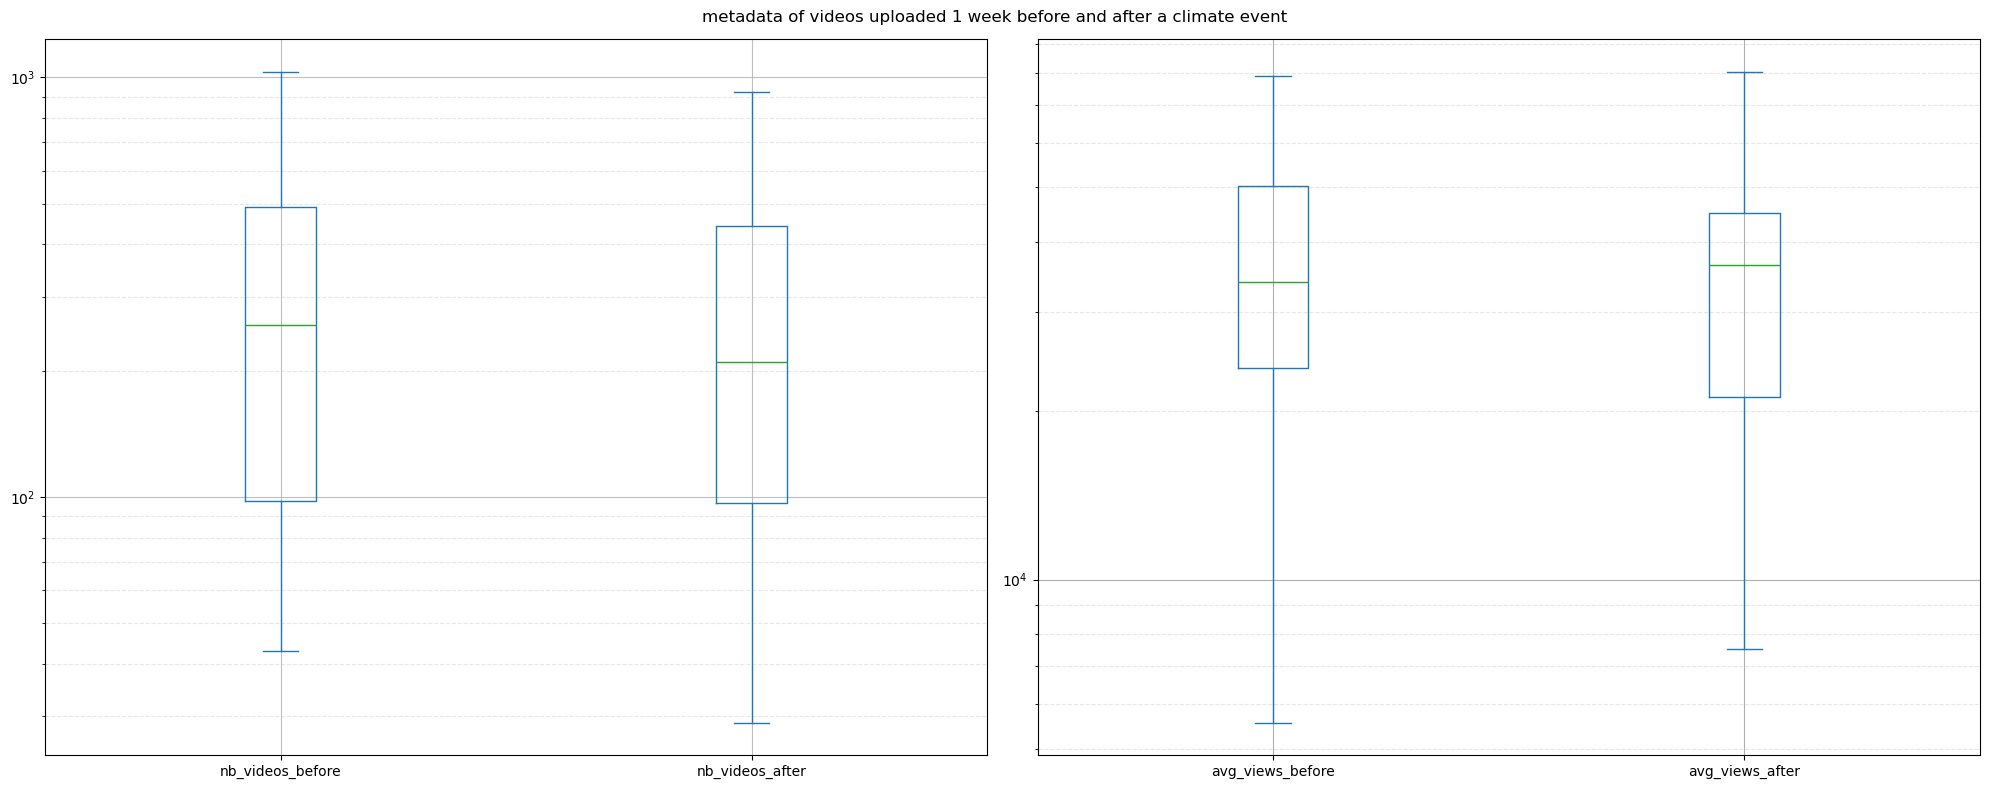

In [30]:
fig, (pA, pB) = plt.subplots(1, 2, figsize=(20, 8))

climate_events[['nb_videos_before', 'nb_videos_after']].plot(kind='box', grid=True, ax=pA, showfliers=False) #, color=color
climate_events[['avg_views_before', 'avg_views_after']].plot(kind='box', grid=True, ax=pB, showfliers=False)
pA.set_yscale("log")
pA.grid(which='minor', alpha=0.3, linestyle='--')
pA.grid(which='major', alpha=0.8)
pB.set_yscale("log")
pB.grid(which='minor', alpha=0.3, linestyle='--')
pA.grid(which='major', alpha=0.8)

fig.suptitle('metadata of videos uploaded 1 week before and after a climate event')
fig.tight_layout()
#plt.legend(['videos not about climate change', 'videos about climate change'], loc='upper right')
#plt.ylabel('Average number of views')
#plt.xlabel('Channel name')
plt.show()

Do videos about climate change make youtubers gain followers?
- for channels with low ratio of cc vids
- for channels with high ratio
- just after an event compared to when there are no events 

-> maybe do a line graph or stacked area graph

In [79]:
timeseries_df = pd.read_csv('DATA/df_timeseries_en.tsv', delimiter='\t')
timeseries_df = timeseries_df.sort_values(by='datetime', ascending=True)
display(timeseries_df.head(10))

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
8698774,UC1Ru5ZqoiF1cFwQSuFuv-KA,Gaming,2015-01-05 00:00:00,3.111235e+06,0.000000,16818.000000,0.000000,0,0,0
2462377,UCnYwVM9uyLGzTFfAkWqiUdQ,Gaming,2015-01-05 00:00:00,2.580014e+07,0.000000,70829.000000,0.000000,1420,0,20
1189482,UCqzju-_WMKsgNx8R3QwupQQ,Howto & Style,2015-01-12 00:00:00,3.307442e+08,441616.500000,456442.000000,0.000000,0,0,0
3640066,UC-IhaHBONjT0JjdOKqC21zQ,Film and Animation,2015-01-12 00:00:00,1.355811e+06,4829.375000,353.875000,0.000000,192,0,2
4470698,UCe8GMzGI_8fBfQYgOe3tBKA,Entertainment,2015-01-12 00:00:00,7.106681e+07,137468.333333,97849.277778,0.000000,34,0,0
2462378,UCnYwVM9uyLGzTFfAkWqiUdQ,Gaming,2015-01-12 00:00:00,2.615005e+07,349900.250000,71531.100000,702.100000,1425,5,20
8698775,UC1Ru5ZqoiF1cFwQSuFuv-KA,Gaming,2015-01-12 00:00:00,3.135948e+06,24713.500000,16873.125000,55.125000,0,0,0
1025450,UCjKOy4vngYbZMSXJbMmJoUQ,Gaming,2015-01-12 00:00:00,4.749135e+07,0.000000,52659.500000,0.000000,191,0,3
4470699,UCe8GMzGI_8fBfQYgOe3tBKA,Entertainment,2015-01-19 00:00:00,7.202908e+07,962278.333333,98915.222222,1065.944444,34,0,0
14594377,UCzqQPiNga359uISQxuKO1Fg,Howto & Style,2015-01-19 00:00:00,2.141333e+02,214.133333,478.000000,0.000000,0,0,0


In [93]:
display(timeseries_df.loc[timeseries_df['datetime'] == '2015-09-28 00:00:00'].sort_values(by='delta_views', ascending=False).head(10))

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
643787,UC_iBYlCqpSV83JYYjySQE0A,Entertainment,2015-09-28 00:00:00,2.155491e+07,2763444.000,41741.250,1488.250,275,0,6
16573404,UCyCTtyAUOliulO9mXBnMnHA,Sports,2015-09-28 00:00:00,1.498717e+07,2260272.000,94338.000,8680.000,2,0,0
4077885,UCp7aooRhiGrdzfurH46aQnQ,Entertainment,2015-09-28 00:00:00,2.149156e+07,1167404.875,110309.250,2567.250,20,2,3
5759998,UCdS7PjPJnhaxGekVfJpS4ww,People & Blogs,2015-09-28 00:00:00,3.139436e+07,490013.125,410661.250,5094.250,20,0,0
4712588,UCAK9xcpdzEXlJn0rh-E4H4A,Howto & Style,2015-09-28 00:00:00,1.103370e+07,223931.750,42384.750,834.750,700,16,30
4680685,UCn42HkmbUavCnHhwnvwpl_g,Entertainment,2015-09-28 00:00:00,1.282391e+06,181976.375,188.125,13.125,0,0,0
14219743,UCQ0qP6koCeknuEjb11DjX_Q,Howto & Style,2015-09-28 00:00:00,2.036267e+07,181318.750,22443.750,117.000,0,0,0
14858253,UCJu0jKgeWPHXivJmNKnIVOA,Autos & Vehicles,2015-09-28 00:00:00,7.155572e+06,179299.625,12149.000,177.750,176,0,3
2425386,UCgDSF6FpenGam-wH747f1iw,Sports,2015-09-28 00:00:00,2.026371e+06,156930.625,8232.375,377.125,216,9,23
12058181,UCt8cpznBEtgFSnz_YytLKzQ,Music,2015-09-28 00:00:00,4.642649e+06,144135.250,6398.000,185.500,208,4,13


In [95]:
display(videos_df.loc[videos_df['channel_id'] == 'UC_iBYlCqpSV83JYYjySQE0A']) #.sort_values(by='delta_views', ascending=False).head(10))

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,view_count
upload_date,,,,,,,,,,,
2015-04-25,People & Blogs,UC_iBYlCqpSV83JYYjySQE0A,2019-10-31 13:47:18.674785,Disturbing Images Of Pollution In China\n\nA F...,67.0,TTAkVghzPQ0,265,390.0,"disturbing,sad,scary,pollution,nature,alarming...",Disturbing & Scary Images Of Pollution In China,107448.0
2015-05-13,People & Blogs,UC_iBYlCqpSV83JYYjySQE0A,2019-10-31 13:47:17.255500,What Cities Would Look Like Without Any Lights...,0.0,K2EFPSvg_Eg,86,8.0,"big cities,without light,environment,paris,Hon...",What Big Cities Would Look Like Without Light?,670.0


In [102]:
#b
timeseries_cc_df = timeseries_df.merge(tt_views_cc_df, how='inner', on='channel')
#display(timeseries_cc_df.sort_values(by="datetime"))
display(ch_views_df.head(2))

,channel,tt_views,tt_videos,tt_cc_views,tt_cc_videos,avg_views_wo_cc,avg_views_w_cc,avg_views,subscribers_cc,proportion_climate_videos,RatioBin
name_cc,,,,,,,,,,,
paul8kangas,UCtYjvLEq6FCTWHUX_qtDJpw,6.981978e+06,11935,834452,2069,623.102126,403.311745,585.000215,22900,0.173066,"[0.14, 0.28)"
TEDx Talks,UCsT0YIqwnpJCM-mx7-gSA4Q,3.734520e+09,141827,24861335,2064,26542.494408,12045.220446,26331.516432,20700000,0.014573,"[0.0, 0.14)"


In [97]:
#a
#timeseries_cc_df = timeseries_df.merge(ch_views_df[ch_views_df['proportion_climate_videos'] > 0.7], how='inner', on='channel')

#display(timeseries_cc_df)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,tt_views,tt_videos,tt_cc_views,tt_cc_videos,avg_views_wo_cc,avg_views_w_cc,avg_views,subscribers_cc,proportion_climate_videos,RatioBin
0,UCKirXBZV7hE4Fws3VSdYkRQ,Education,2016-06-20 00:00:00,9.193848e+05,8334.750000,15891.750000,0.000000,57,0,0,5.506280e+06,206,5008132,161,11069.949206,31106.409938,26729.513176,116000,0.763033,"[0.7, 0.84)"
1,UCKirXBZV7hE4Fws3VSdYkRQ,Education,2016-06-27 00:00:00,9.278224e+05,8437.625000,16014.625000,122.875000,57,0,0,5.506280e+06,206,5008132,161,11069.949206,31106.409938,26729.513176,116000,0.763033,"[0.7, 0.84)"
2,UCKirXBZV7hE4Fws3VSdYkRQ,Education,2016-07-04 00:00:00,9.388025e+05,10980.125000,16166.000000,151.375000,57,0,0,5.506280e+06,206,5008132,161,11069.949206,31106.409938,26729.513176,116000,0.763033,"[0.7, 0.84)"
3,UCKirXBZV7hE4Fws3VSdYkRQ,Education,2016-07-11 00:00:00,9.534558e+05,14653.250000,16375.875000,209.875000,59,2,2,5.506280e+06,206,5008132,161,11069.949206,31106.409938,26729.513176,116000,0.763033,"[0.7, 0.84)"
4,UCKirXBZV7hE4Fws3VSdYkRQ,Education,2016-07-18 00:00:00,9.700182e+05,16562.500000,16635.250000,259.375000,61,2,4,5.506280e+06,206,5008132,161,11069.949206,31106.409938,26729.513176,116000,0.763033,"[0.7, 0.84)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,UCKirXBZV7hE4Fws3VSdYkRQ,Education,2019-08-26 00:00:00,5.280868e+06,41930.655844,110377.642857,1139.461039,205,0,0,5.506280e+06,206,5008132,161,11069.949206,31106.409938,26729.513176,116000,0.763033,"[0.7, 0.84)"
167,UCKirXBZV7hE4Fws3VSdYkRQ,Education,2019-09-02 00:00:00,5.378895e+06,98027.500000,112825.142857,2447.500000,205,0,0,5.506280e+06,206,5008132,161,11069.949206,31106.409938,26729.513176,116000,0.763033,"[0.7, 0.84)"
168,UCKirXBZV7hE4Fws3VSdYkRQ,Education,2019-09-09 00:00:00,5.465901e+06,87005.956044,115005.846154,2180.703297,205,0,0,5.506280e+06,206,5008132,161,11069.949206,31106.409938,26729.513176,116000,0.763033,"[0.7, 0.84)"
169,UCKirXBZV7hE4Fws3VSdYkRQ,Education,2019-09-16 00:00:00,5.486778e+06,20876.692308,115585.769231,579.923077,206,1,1,5.506280e+06,206,5008132,161,11069.949206,31106.409938,26729.513176,116000,0.763033,"[0.7, 0.84)"


In [103]:
timeseries_cc_df['datetime'] = pd.to_datetime(timeseries_cc_df['datetime'])
#timeseries_cc_df.set_index('datetime', inplace=True)

datetime
2015-10-04    2.763444e+06
2017-01-15    1.658602e+06
2019-03-03    1.252441e+06
2019-08-11    1.237448e+06
2019-06-02    1.235487e+06
2015-10-11    1.235470e+06
2019-02-24    1.226159e+06
2019-09-29    1.216183e+06
2019-07-28    1.215311e+06
2019-09-22    1.203929e+06
Name: delta_views, dtype: float64

<Axes: xlabel='datetime'>

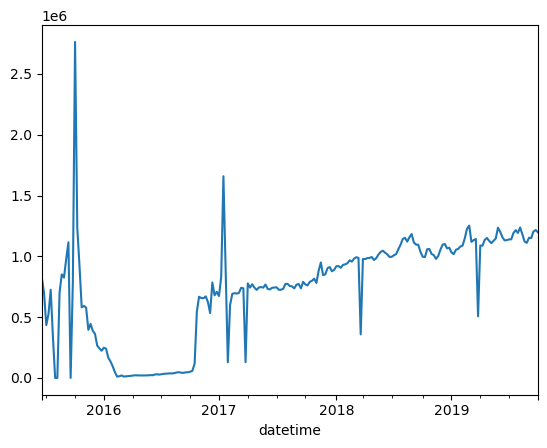

In [105]:
avg_week_view_df = timeseries_cc_df.groupby(pd.Grouper(key='datetime', freq='W'))['delta_views'].mean().dropna()

display(avg_week_view_df.sort_values(ascending=False).head(10))
avg_week_view_df.plot()

<Axes: xlabel='datetime'>

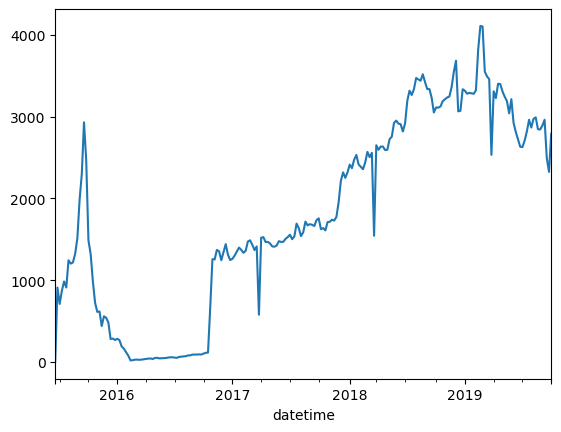

In [166]:
avg_gain_sub_df = timeseries_cc_df.groupby(pd.Grouper(key='datetime', freq='W'))['delta_subs'].mean().dropna()
avg_gain_sub_df.plot()

In [43]:
climate_events['before_event'] = pd.to_datetime(climate_events['before_event'])
climate_events['after_event'] = pd.to_datetime(climate_events['after_event'])

trump_paris_agr = climate_events[climate_events['date'] == '2016-11-08']
#2017-06-01,Trump Announces Withdrawal from Paris Agreement
#2016-11-08
display(trump_paris_agr)

,date,name_of_event,before_event,after_event,nb_videos_before,nb_videos_after,avg_views_before,avg_views_after
36,2016-11-08,Donald Trump Elected Climate Change Policy Con...,2016-10-31,2016-11-15,570.0,442.0,16156.749123,16675.176471


datetime
2016-10-24    615344.610147
2016-10-30    725358.524621
2016-10-31     22954.166788
2016-11-06    725388.694669
2016-11-07     21480.420253
2016-11-13    725715.070302
2016-11-14     21869.534138
2016-11-20    745262.648649
2016-11-21     21855.357455
2016-11-27    694953.194126
2016-11-28     22807.239616
Name: delta_views, dtype: float64

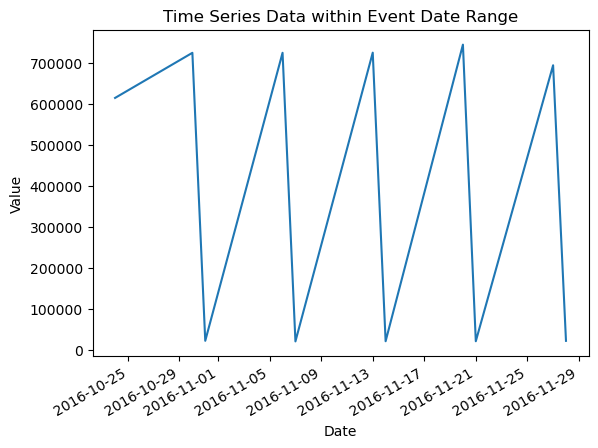

In [44]:
#avg_week_view_filt_df.plot()

avg_week_view_filt_df = avg_week_view_df[
    (avg_week_view_df.index > (trump_paris_agr['date'].iloc[0]  - pd.Timedelta(days=20))) &
    (avg_week_view_df.index <= (trump_paris_agr['date'].iloc[0] + pd.Timedelta(days=20)))
]

display(avg_week_view_filt_df)

# Plot the graph
#plt.plot(avg_week_view_filt_df['Date'], avg_week_view_filt_df['Value'], marker='o', linestyle='-', color='b')
avg_week_view_filt_df.plot()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data within Event Date Range')
plt.show()

In [77]:
#videos_df['upload_date'] = pd.to_datetime(videos_df['upload_date'])
trump_paris_agr_vids_df = videos_df.loc['2015-09-27'].sort_values(by='view_count', ascending=False)
# interesting channels: UC1yBKRuGpC1tSM73A0ZjYjQ UCaXkIU1QidjPwiAYu6GcHjg # UCZaT_X_mc0BI-djXOlfhqWQ
display(trump_paris_agr_vids_df.head()) #['description'].iloc[0]

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,view_count
upload_date,,,,,,,,,,,
2015-09-27,Science & Technology,UCZ7qe4QUGie6jtJPPEHQx7Q,2019-11-01 02:33:39.355314,Gadgets and Inventions | Hoverboard Personal E...,393.0,9FxvBFPTtWQ,610,4478.0,"inventions you didn't know existed,cool invent...",Gadgets and Inventions | Hoverboard Electric T...,1345849.0
2015-09-27,News & Politics,UCME81PohuzT1JMCsEtvsD2w,2019-11-10 05:34:17.192341,A massive sinkhole in Queensland has swallowed...,8.0,zQSFQGoztDI,75,189.0,"massive sinkhole,natural disaster,Queensland,s...",Giant sinkhole opens up on Australia beach,368704.0
2015-09-27,Science & Technology,UCTiL1q9YbrVam5nP2xzFTWQ,2019-11-04 14:38:02.495876,Observing the Frontier Conference:\nPittsburgh...,77.0,GRjNtRrl04g,322,1379.0,"suspicious0bservers,suspicious observers,ben d...","Big Announcement, Supermoon Eclipse | S0 News ...",108702.0
2015-09-27,News & Politics,UCDGknzyQfNiThyt4vg4MlTQ,2019-11-11 22:29:49.702953,President Obama delivers remarks at the Closin...,490.0,ZcIDkkEBYdQ,1680,912.0,Sustainable Development Goals,The President Speaks at the 2030 Agenda for Su...,101312.0
2015-09-27,Travel & Events,UCwr5wb0SOrAB_V9n5jCPx5g,2019-11-18 13:11:13.067139,Various shots from the 2015 Blood Moon and Lun...,15.0,5LqpA8EJE74,86,361.0,"Tom Dreams BIG,Blood Moon,Lunar Eclipse,28/09/...",Red Super Moon Eclipse ! HD,45928.0


In [185]:
imp_events = pd.read_csv('DATA/climate_events_v2.csv')
display(imp_events.head(2))
imp_events['Date'] = pd.to_datetime(imp_events['Date'])
imp_events.set_index('Date', inplace=True)

climate_events.set_index('date', inplace=True)

,Date,Event Name,Short Description
0,2010-04-20,Deepwater Horizon Oil Spill,A devastating oil spill in the Gulf of Mexico...
1,2010-08-01,Russian Heat Wave,Unprecedented heatwave in Russia leading to w...


KeyError: "None of ['date'] are in the columns"

C:\Users\nasta\AppData\Local\Temp\ipykernel_24952\1188966153.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ch['datetime'] = pd.to_datetime(ch['datetime'])
C:\Users\nasta\AppData\Local\Temp\ipykernel_24952\1188966153.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ch['datetime'] = pd.to_datetime(ch['datetime'])
C:\Users\nasta\AppData\Local\Temp\ipykernel_24952\1188966153.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

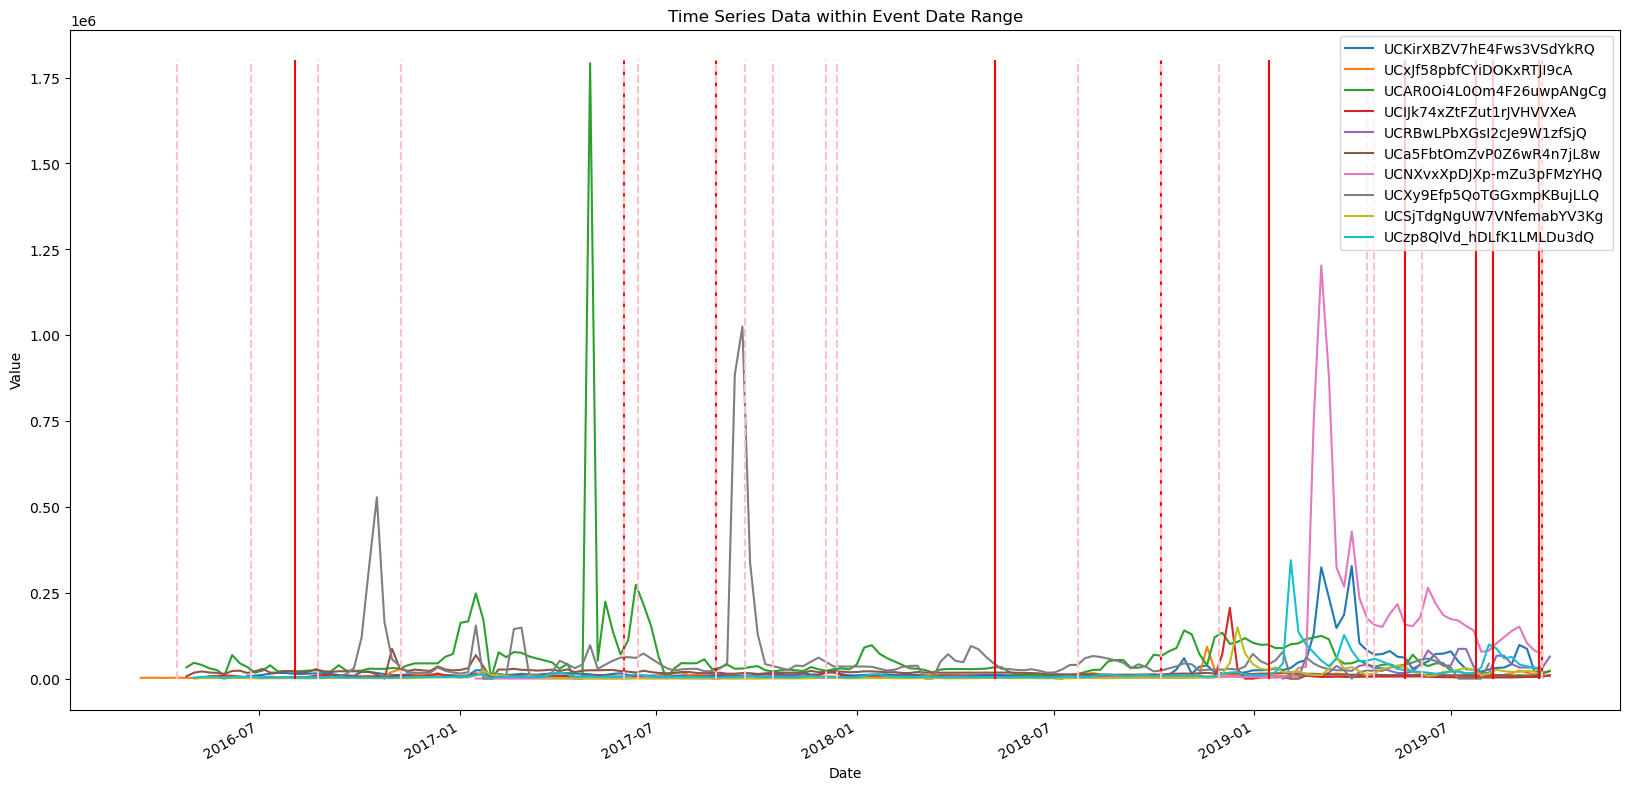

In [180]:
ch_list = [timeseries_cc_df[timeseries_cc_df['channel'] == 'UCKirXBZV7hE4Fws3VSdYkRQ'], 
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCxJf58pbfCYiDOKxRTJI9cA'],
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCAR0Oi4L0Om4F26uwpANgCg'], 
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCIJk74xZtFZut1rJVHVVXeA'], 
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCRBwLPbXGsI2cJe9W1zfSjQ'],
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCa5FbtOmZvP0Z6wR4n7jL8w'],
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCNXvxXpDJXp-mZu3pFMzYHQ'],
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCXy9Efp5QoTGGxmpKBujLLQ'],
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCSjTdgNgUW7VNfemabYV3Kg'],
           timeseries_cc_df[timeseries_cc_df['channel'] == 'UCzp8QlVd_hDLfK1LMLDu3dQ']
]

fig = plt.figure(figsize=(20, 10))

for ch in ch_list:
    ch['datetime'] = pd.to_datetime(ch['datetime'])
    ch.set_index('datetime', inplace=True)
    ch['delta_views'].plot(label=ch['channel'].iloc[0], legend=True, alpha=0.5)

plt.vlines(imp_events.loc['2016':'2019-10'].index, 0, ymax=1800000, colors='r', label="Important events")
plt.vlines(climate_events.loc['2016':'2019-10'].index, 0, ymax=1800000, colors='pink', linestyles='--', label="Important events")

#display(ch_1.sort_values(by='delta_views', ascending=False).head(10))
#ch_1['datetime'] = pd.to_datetime(ch_1['datetime'])
#ch_1.set_index('datetime', inplace=True)

#ch_1_filt_df = ch_1[
#    (ch_1.index > (trump_paris_agr['date'].iloc[0]  - pd.Timedelta(days=20))) &
#    (ch_1.index <= (trump_paris_agr['date'].iloc[0] + pd.Timedelta(days=20)))
#]

#ch_1['delta_views'].plot()
#ch_1_filt_df['delta_views'].plot()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data within Event Date Range')
plt.show()

Tous les pics au dessus de 25 milles ne correspondent pas à des cc vids ou si elles le sont elles n'ont rien à voir avec des events

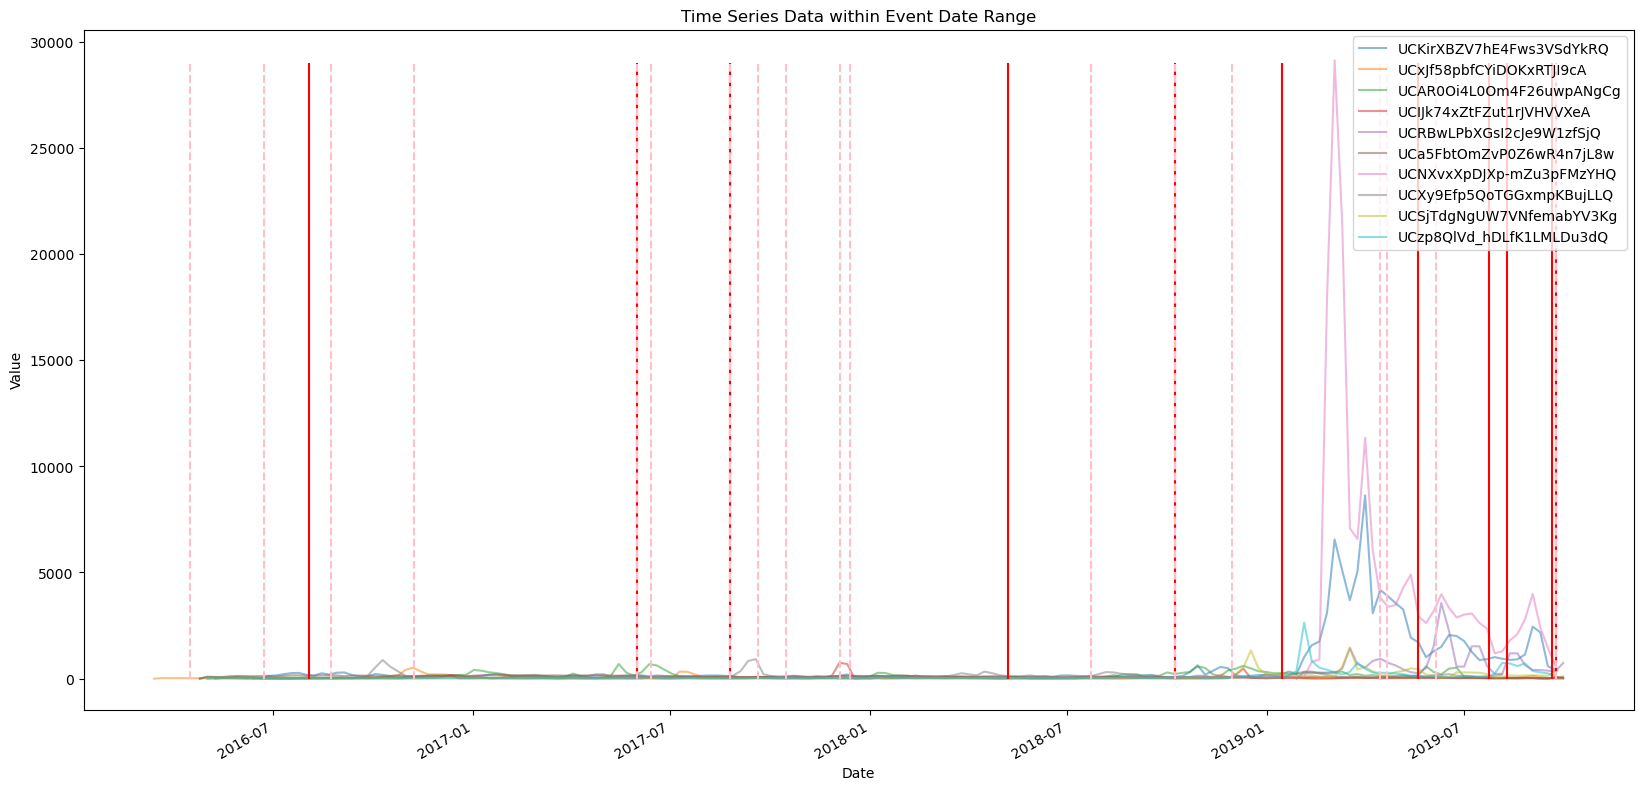

In [165]:
fig = plt.figure(figsize=(20, 10))

for ch in ch_list:
    #ch['datetime'] = pd.to_datetime(ch['datetime'])
    #ch.set_index('datetime', inplace=True)
    ch['delta_subs'].plot(label=ch['channel'].iloc[0], legend=True, alpha=0.5)

plt.vlines(imp_events.loc['2016':'2019-10'].index, 0, ymax=29000, colors='r', label="Important events")
plt.vlines(climate_events.loc['2016':'2019-10'].index, 0, ymax=29000, colors='pink', linestyles='--', label="Important events")

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data within Event Date Range')
plt.show()

In [184]:
display(videos_df.loc[videos_df['channel_id'] == 'UCXy9Efp5QoTGGxmpKBujLLQ'].loc[:'2017'].sort_values(by='view_count', ascending=False).head(10))

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,view_count
upload_date,,,,,,,,,,,
2017-05-23,Science & Technology,UCXy9Efp5QoTGGxmpKBujLLQ,2019-11-03 05:16:04.095345,The East Siberian Arctic Shelf has received mo...,30.0,eJfOWfaP6RI,688,467.0,"Natalia Shakhova,University of Alaska Fairbank...",Methane in the East Siberian Arctic Shelf (2017),56621.0
2017-11-23,Science & Technology,UCXy9Efp5QoTGGxmpKBujLLQ,2019-11-03 05:16:00.365574,Rapid collapse of Antarctic glaciers could flo...,72.0,Pp5kK0Td-Vc,707,557.0,"Eric Holthaus,Pine Island Glacier,Thwaits Glac...",Ice Apocalypse - MULTIPLE METERS SEA LEVEL RISE,54646.0
2017-06-10,News & Politics,UCXy9Efp5QoTGGxmpKBujLLQ,2019-11-03 05:16:01.892955,One idea likely to be both controversial and e...,39.0,FadyWlTdi2Y,878,199.0,"SLR,Sea level rise,Miami,Shorecrest,South Flor...",Florida plans to abandon Property to the Sea (...,18513.0
2017-06-07,Science & Technology,UCXy9Efp5QoTGGxmpKBujLLQ,2019-11-03 05:16:02.472732,"For the first time, underwater pingos have bee...",8.0,9XmRzMwITjA,325,176.0,"Pingo,gas hydrate pingo,CAGE,Center for Arctic...",Large Underwater Methane seeping Structures ca...,11326.0
2017-06-04,Science & Technology,UCXy9Efp5QoTGGxmpKBujLLQ,2019-11-03 05:16:02.989961,Like ‘champagne bottles being opened’: Scienti...,3.0,9q3c9CErdmA,611,119.0,"Stephen Grasby,CAGE,Methane,methane hydrate,cl...","Like Champagne Bottles Pop, Methane Explosions...",5045.0
2017-06-13,Education,UCXy9Efp5QoTGGxmpKBujLLQ,2019-11-03 05:16:00.855331,"Yoda, Luke and C3PO explain surprising climate...",8.0,2eaMz0lMg10,257,41.0,"wet-bulb temperature,weather,superstorms,snows...",5 Surprising Climate Change Effects,1236.0
